# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau

  - Exemples de référence

  - Analyse des ensembles de niveau (Q1, Q2, Q3, Q4)

- Construction des courbes de niveau

  - Méthode de Newton (Q5, T1, T2)

  - Génération des points (Q6, T3)

  - Bouclage et auto-intersection (Q7, T4, T5)

- Post-traitement

  - Interpolation (Q8, T6)

  - Intégration (T7, T8)

## Préambule

### Dépendances logicielles 

In [4]:
# Python Standard Library
# -----------------------
pass

In [5]:
# Third-Party Libraries
# ---------------------

# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [6]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [7]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

#### Exemples d'usage

In [8]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(0.0, 0.0) # array([1., 2.])

array([1., 2.])

In [9]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

#### Précautions

Les deux sources d'erreurs (avec messages cryptiques) les plus communes avec autograd :

**Selection de NumPy**

N'importez pas NumPy directement, par exemple avec

    >>> import numpy as np # Wrong !

mais importez le module `numpy` qui a été modifié par `autograd` (pour que les fonctions du module "coopérent" avec les algorithmes de différentiation automatique). 

    >>> import autograd.numpy as np # Right !
    
Utilisez-le ensuite comme vous le feriez avec NumPy classique.

**Utilisez des doubles**

Les fonctions générées par autograd sont strictes quand au type des nombres utilisés (plus strictes que les fonctions NumPy) : il doit s'agir de doubles. Par exemple, si l'on définit

    >>> def add(x, y):
    ...    return x + y
    >>> grad_add = grad(add)

Alors `grad_add(0.0, 0.0)` renvoie `array([1.0, 1.0])`, mais `grad_add(0, 0)` génère une erreur, car ses arguments sont des entiers et non des doubles.


## Ensembles de niveau

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x_1,x_2) \in \mathbb{R}^2 \; | \; f(x_1, x_2) = c\}.
$$


### Exemples de référence

On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [10]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [11]:
def f1(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return 3.0 * x1 * x1 - 2.0 * x1 * x2 + 3.0 * x2 * x2 

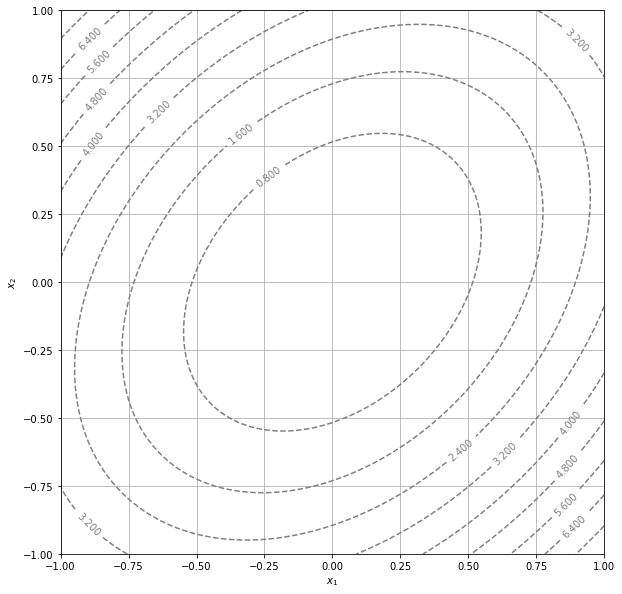

In [12]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x_1,x_2) \in \mathbb{R}^2 \mapsto (x_1 - 1)^2 + (x_1 - x_2^2)^2
$$

In [13]:
def f2(x1, x2):
    return (x1 - 1)**2 + (x1 - x2**2)**2

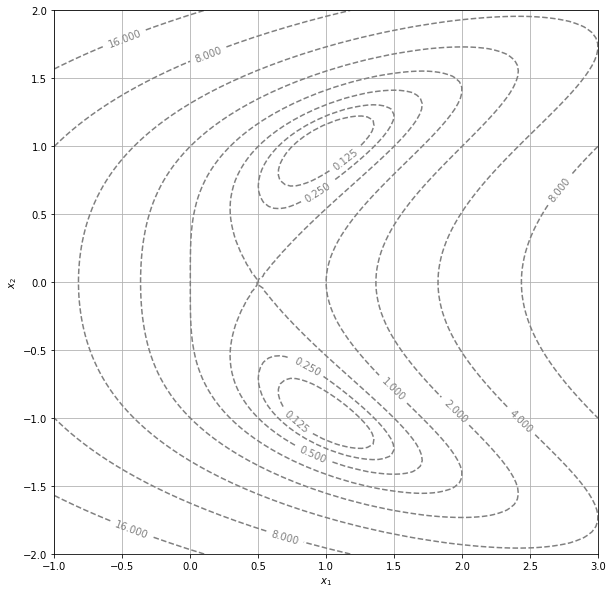

In [14]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [15]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

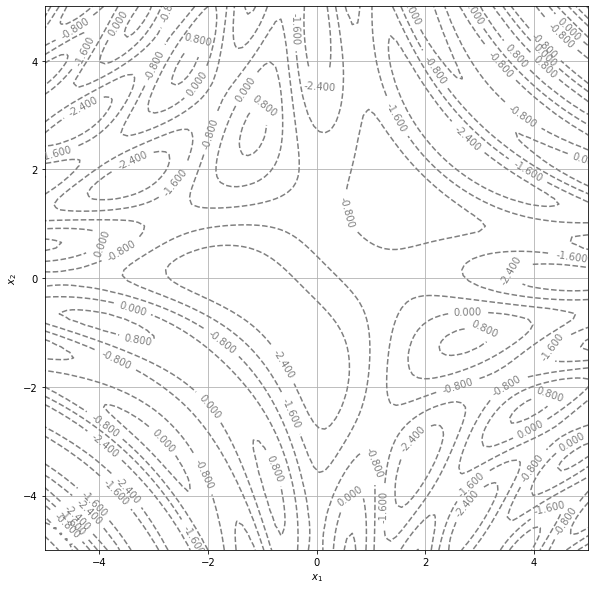

In [16]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

### Analyse des ensembles de niveau

#### Question 1

Soit $c \in \mathbb{R}$.
On suppose que la fonction $f:\mathbb{R}^2 \to \mathbb{R}$ est continue et vérifie
$f(x_1, x_2) \to +\infty$ quand $\|(x_1,x_2)\| \to +\infty$.
Que peut-on dire de l'ensemble de niveau $c$ de $f$ ?

Il est borné. En effet par la définition de la limite infinie $ \forall c \in \mathbb{R} , \  \exists A \in \mathbb{R+} $tel que $  \|(x_1,x_2)\| >=  A \implies f(x_1,x_2)>c    \\ $
De plus il est fermé comme image réciproque par $ f $, une fonction continue du fermé $ \{c\}$

Dans la suite la fonction $f$ est supposée continûment différentiable. On suppose également que le gradient $\nabla f$ ne s'annule pas dans un voisinage du point $x_0 = (x_{10}, x_{20}) \in \mathbb{R}^2$. On pose alors
$$
p(x_1, x_2) := \frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} (x_1 - x_{10}) -
\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} (x_2 - x_{20}).
$$




#### Question 2
Comment interpréter géométriquement le terme $p(x_1,x_2)$ ?

-> determinant, le x1 et x2 sont inversés, c'est une espece d'aire orientée

$ p(x_1,x_2)= \begin{vmatrix} (x_1 - x_{10}) & {\partial_1 f(x_0)} \over {|| \nabla f(x_0)||} \\ (x_2 - x_{20}) & {\partial_2 f(x_0)} \over {|| \nabla f(x_0)||} \end{vmatrix} $


C'est le determinant entre un vecteur X, éplacement qcq par rapport à $ \begin{pmatrix} x_0 \\ y_0 \end{pmatrix}$ et $ \nabla f $, $ \forall \epsilon \exists V $ voisinage  de $x_0 $ tq $ p(x_1,x_2) $ maximal a $ ||(x_1,x_2)||=cte ) \iff d(x,ligne \ de \ niveau \ c) \leq \epsilon $.

#### Question 3

Montrer que dans un voisinage ouvert de $x_0$, on peut paramétriser l'ensemble de niveau $c:=f(x_0)$ au moyen de $p(x_1,x_2),$ c'est-à-dire qu'il existe un $\varepsilon > 0$ et une fonction (continûment différentiable) $\gamma :\left]-\varepsilon,\varepsilon \right[ \to \mathbb{R}^2$ tels que dans un voisinage ouvert de $x_0,$ $f(x_1,x_2) = c$ si et seulement si $(x_1, x_2) = \gamma(t)$ où $t = p(x_1, x_2)$.

-> Thm des fonctions implicites sur p

Localement autour de f(x0) la fonction est "lisse", donc k position sur la ligne d eniveau -> p(x1,x2) est monotone, donc 

on pose $ g : \begin{matrix} \mathbb{R}^2  \times \mathbb{R} & \to & \mathbb{R}^2 \\ (x_1,x_2,t) & \mapsto & (f(x_1,x_2)-c \ ,p(x_1,x_2)-t) \end{matrix}  $

#### Question 4

Montrer que pour tout $t \in \left]-\varepsilon, \varepsilon \right[$ :

  - le vecteur $\gamma'(t)$ est non nul (il fournit donc une tangente au chemin $\gamma$),

  - est orthogonal à $\nabla f(\gamma(t))$.

idée : supposer par l'absurde $ \gamma $ nul et on doit pouvoir montrer que $ \nabla f $ l'est aussi


## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $x_0 \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

#### Question 5

L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [17]:
N = 100

#L'ordre de grandeur est empirisue, pour des fonctions qui ne "varient pa trop" on peut prendre :
eps = 10**-2

#### Tâche 1

Implémenter la fonction `Newton` en complétant le canevas ci-dessous

Newton "classique" : on utilise le DL1 : $ f(x+h)=f(x)+f'(x)h+o(h)$ on fait donc l'approximation linéaire de f et on trouve qu'alors il y a annulation en $ h= {  {-f(x)} \over {f'(x)}}$

Ici on fait pareil mais avec un DL d'ordre supérieur : $f(x+h)=f(x) + J_f(x) h + o(||h||)$ ce qui amène, en faisant une approximation linéaire et en supposant $J_f(x)$ inversible à f s'annulant pour $h={- J_f(x)^{-1} . f(x) }$

In [27]:
N=100
eps=10**-2

def Newton(F, x0, y0, eps=eps, N=N):
    J_f=J(F)
    for i in range(N):
        val=F(x0,y0)
        Jac=J_f(x0,y0)
        H=-np.linalg.inv(Jac).dot(val)
        x,y=x0+H[0],y0+H[1]
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y
        x0, y0 = x, y
    raise ValueError(f"no convergence in {N} steps.")




#### Tâche 2
Testez votre implémentation de la fonction `Newton` !
On suggère par exemple de l'utiliser pour chercher un point $ (x_1, x_2)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x_1 = x_2 $ en utilisant le point initial $(0.8, 0.8)$. Puis de faire varier le point initial, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

In [39]:
def ftest(x,y):
    return(np.array([f1(x,y)-0.8,x-y]))

Newton(ftest, 0.8,0.8)

(0.447250250297228, 0.447250250297228)

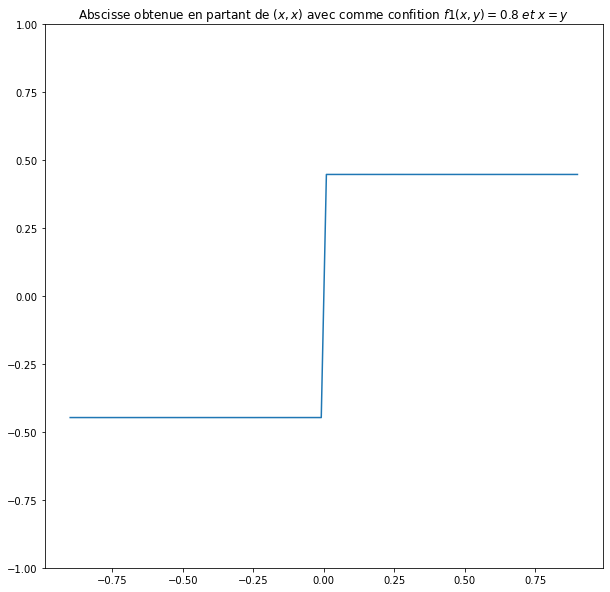

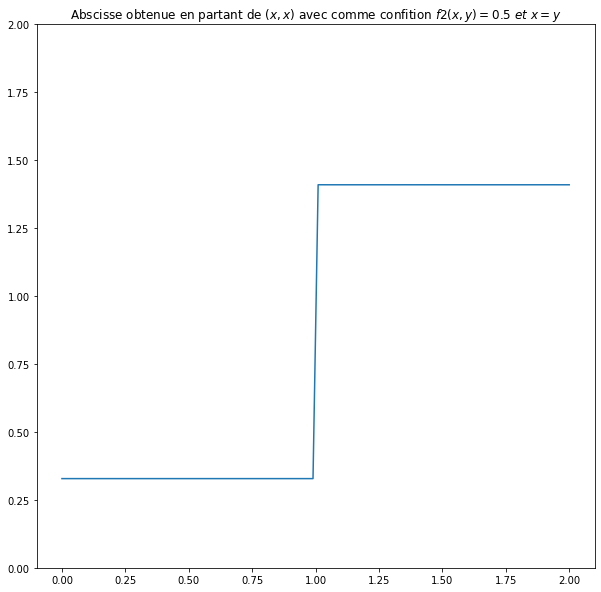

In [20]:
L=np.linspace(-0.9,0.9,100)
F=np.zeros(L.size,dtype='float')
for i in range(L.size):
    F[i]=Newton(ftest,L[i],L[i])[0]
plt.figure()

plt.title("Abscisse obtenue en partant de $(x,x)$ avec comme confition $f1(x,y)=0.8 \ et \ x=y$" )
plt.ylim(-1,1)
plt.plot(L,F)

def ftest2(x,y):
    return(np.array([f2(x,y)-0.5,x-y]))
    
L=np.linspace(0,2,100)
F=np.zeros(L.size,dtype='float')
for i in range(L.size):
    F[i]=Newton(ftest2,L[i],L[i])[0]
plt.figure()
plt.title("Abscisse obtenue en partant de $(x,x)$ avec comme confition $f2(x,y)=0.5 \ et \ x=y$" )
plt.ylim(0,2)
plt.plot(L,F)

On remarque qu'il y a des sauts lorsqu'on change de zone attractive.

### Génération des points

#### Question 6 + Tâche 3
Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille `(2, N)` contenant les coordonnées des points correspondants, puis valider graphiquement le résultat au moyen des exemples de référence.

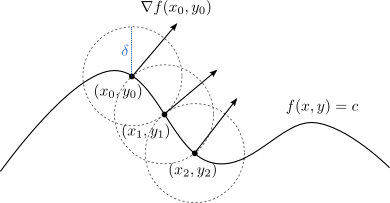

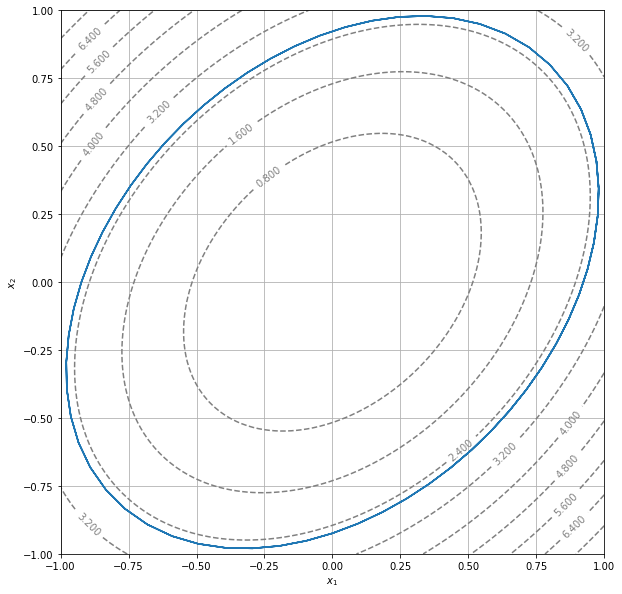

In [66]:


Nnew=100 #paramètrre de l'algo de Newton
eps=10**-2

def level_curve(f, x0, y0, delta=0.1, N=100, eps=eps):
   c=f(x0,y0)
   grad_f=grad(f)
   def F(x,y):
      return(np.array([f(x,y)-c, (x*0.999999-x0)**2 + (y*0.999999-y0)**2 - delta*delta]))

   def determine_suivant(x,y,delta):
      """cherche le déplacement optimal pour se rapprocher du point suivant, dans l'hypothèse d'une fonction suffisament 'lisse' pour être approximée par une fonction linéaire. On cherche le vecteur n orthogonal au gradient et à sa droite : n.grad_f = 0 et |n,grad_f|>0 (formule inspirée par la fonction p). """
      d1f,d2f=grad_f(x,y)
      if d1f==0 and d2f==0:
         return x0,y0
         #raise Exception("Erreur : le gradient est nul on est sur un palier ou un point d'inflexion")
      if d1f==0: #les if permettent de gérer le cas pathologique d'un gradient vertical
         n2=0
         n1=1
         if n1*d2f-n2*d2f<0:
            n1=-1
      else:
         n2=1
         n1=-d2f/d1f
         if n1*d2f-n2*d1f<0:
            n1=-n1
            n2=-n2
      deplacement=np.array([n1,n2])*delta/np.sqrt(n1**2 + n2**2) #on normalise pour se deplacer de delta
      return x+deplacement[0],y+deplacement[1]
      

   courbe = np.zeros((2,N))

   for i in range(N):
      x1,y1=determine_suivant(x0,y0,delta) #on se rapproche du suivant "tout droit"
      x,y=Newton(F,x1,y1,eps,Nnew) #on laisse le point se faire aspirer vers la ligne de niveau
      courbe[:,i]=x,y
      x0,y0=x,y

   return courbe


courbe = level_curve(f1,0.8,0.8,delta=10**-1,N=200)

abscisses = courbe[0,:]
ordonnees = courbe[1,:]

display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

plt.plot(abscisses,ordonnees)




### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

#### Question 7 + Tâche 4

Proposer une nouvelle implémentation de `level_curve` qui arrête l'algorithme et renvoie les points connus quand le segment formé par les deux derniers points produits intersecte l'un des segments produits auparavant. En étant (raisonnablement) optimiste, doit-t'on prendre la peine de tester l'intersection du dernier segment avec tous les segments déjà produits (ce qui prend du temps ...) ou juste avec le premier ? Pour répondre à cette question, on pourra se demander si les courbes de niveau similaires à celle de la fonction de Rosenbrock passant par le point $(0.5, 0)$ (cf. Exemples de référence) -- c'est-à-dire "auto-intersectantes" -- sont fréquentes ou rares et pourquoi.

Arret : on a recroisé le premier segment au bout de 62 étapes


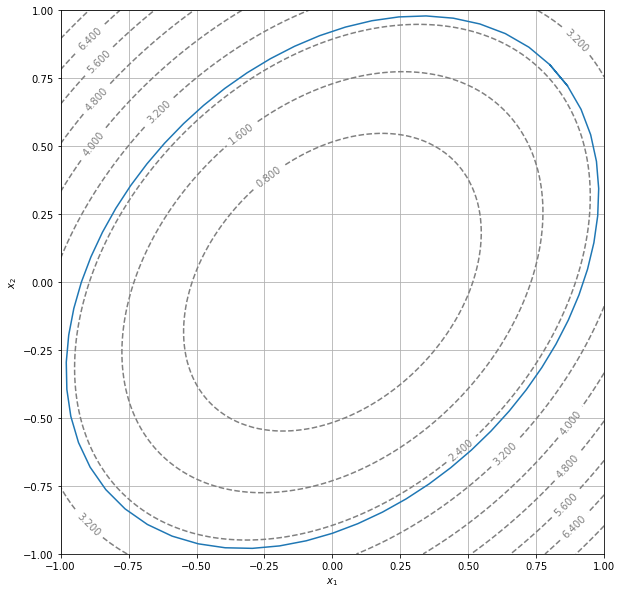

In [116]:
Nnew=100 #paramètrre de l'algo de Newton
eps=10**-2



def se_croisent(xa,ya,xb,yb,xc,yc,xd,yd):
    "calcule les 4 déerminants pour voir si les segments AB et CD se croisent"
    det1=(xd-xc)*(ya-yc)-(yd-yc)*(xa-xc)
    det2=(xd-xc)*(yb-yc)-(yd-yc)*(xb-xc)
    det3=(xb-xa)*(yd-ya)-(yb-ya)*(xd-xa)
    det4=(xb-xa)*(yc-ya)-(yb-ya)*(xc-xa)

    if det1*det2<0 and det3*det4<0:
        return True
    return False

def level_curve(f, x0, y0, delta=0.1, N=100, eps=eps):
   c=f(x0,y0)
   grad_f=grad(f)
   def F(x,y):
      return(np.array([f(x,y)-c, (x*0.999999-x0)**2 + (y*0.999999-y0)**2 - delta*delta]))

   def determine_suivant(x,y,delta):
      """cherche le déplacement optimal pour se rapprocher du point suivant, dans l'hypothèse d'une fonction suffisament 'lisse' pour être approximée par une fonction linéaire. On cherche le vecteur n orthogonal au gradient et à sa droite, de norme delta, et on l'ajoute au vecteur position """
      d1f,d2f=grad_f(x,y)
      n1,n2=d2f,-d1f #rotation de pi/2
      deplacement=np.array([n1,n2])*delta/np.sqrt(n1**2 + n2**2) #on normalise pour se deplacer de delta
      return x+deplacement[0],y+deplacement[1]
      

   courbe = [[x0,y0]]

   for i in range(N):
      x1,y1=determine_suivant(x0,y0,delta) #on se rapproche du suivant "tout droit"
      x,y=Newton(F,x1,y1,eps,Nnew) #on laisse le point se glisser vers la ligne de niveau
      courbe.append([x,y])
      if se_croisent(courbe[0][0],courbe[0][1],courbe[1][0],courbe[1][1],x,y,courbe[-2][0],courbe[-2][1]):
          courbe.pop()
          print(f"Arret : on a recroisé le premier segment au bout de {i} étapes")
          return np.array(courbe).transpose()
      courbe.append([x,y])      
      x0,y0=x,y

   return np.array(courbe).transpose()


#Le boui-boui qui suit est pour l'affichage


courbe = level_curve(f1,0.8,0.8,delta=10**-1,N=200)
display_contour(
f1, 
x=np.linspace(-1.0, 1.0, 100), 
y=np.linspace(-1.0, 1.0, 100), 
levels=10 # 10 levels, automatically selected
)

abscisses = courbe[0,:]
ordonnees = courbe[1,:]

plt.plot(abscisses,ordonnees)




#### Tâche 5

Valider graphiquement le résultat au moyen des exemples de référence.

206


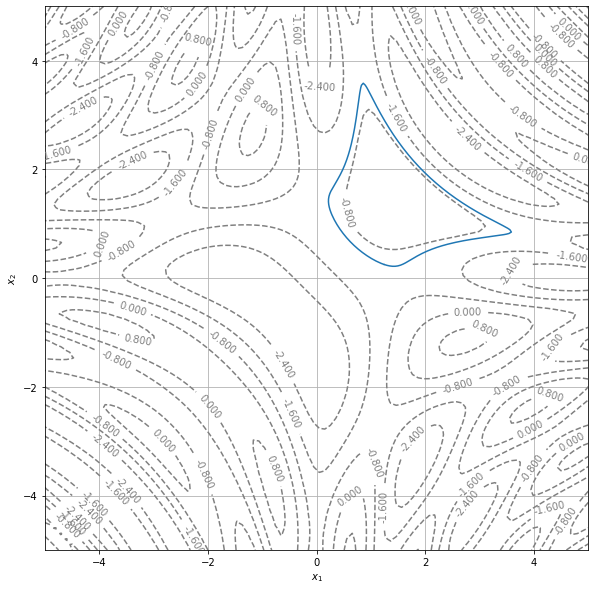

In [115]:

#k permet de choisir parmi les differentes fonction celle dont on veut executer la démo

k=3

if k==1:
    courbe = level_curve(f1,0.447,0.447,delta=10**-1,N=200)
    display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
    )

if k==2:
    display_contour(
        f2, 
        x=np.linspace(-1.0, 3.0, 100), 
        y=np.linspace(-2.0, 2.0, 100), 
        levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
    )
    courbe = level_curve(f2,1.,0.,delta=10**-2,N=1000)

if k==3:
    display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
    )
    courbe = level_curve(f3,1.25,0.25,delta=5*10**-2,N=500)


abscisses = courbe[0,:]
ordonnees = courbe[1,:]

plt.plot(abscisses,ordonnees)

## Post-traitement

Pour améliorer le rendu des courbes de niveau, il est tentant de diminuer la distance $\delta$ entre deux points consécutifs. Malheureusement, dans des cas d'usage réalistes, il est fréquent que la fonction $f$ soit beaucoup plus complexe que les exemples qui nous avons considérés. Le nombre de fois où cette fonction est appelée est alors le principal facteur qui détermine le temps de calcul des lignes de niveau. On cherche donc dans cette section à améliorer la qualité visuelle des résultats sans faire exploser le nombre d'évaluation de la fonction $f$. On va chercher à résoudre ce problème en reliant les points successifs par des chemins plus "flexibles" que des segments de droites, ayant le potentiel de mieux coller aux lignes de niveau.

### Interpolation 

#### Question 8

Soit $P_1$ et $P_2$ deux points du plan et $u_1$ et $u_2$ deux vecteurs du plan non nuls.
On cherche à produire un chemin $\gamma: [0,1] \to \mathbb{R}^2$ continûment différentiable, joignant $P_1$ et $P_2$ ($\gamma(0) = P_1$ et $\gamma(1) = P_2$), tel que $\gamma'(0)$ soit dans la même direction et le même sens que $u_1$ et $\gamma'(1)$ soit dans la même direction et le même sens que $u_2$.

On recherche une telle solution sous la forme
$\gamma(t) = (x(t), y(t))$ où 
$$
x(t) = a + bt + ct^2 \; \mbox{ et } \; y(t) = d + et + ft^2
$$
et les paramètres réels $a, b, c, d, e, f$ sont à déterminer(*).


Déterminer les coefficients $a, b, c, d, e, f$ solutions de ce problème quand ils existent.
Expliciter si nécessaire les conditions que doivent remplir $P_1$, $P_2$, $u_1$ et $u_2$ pour qu'une solution existe.

(*) Cf. ["Mathematical Typography" de Donald E. Knuth](https://projecteuclid.org/euclid.bams/1183544082) pp. 354-359 (Bull. Amer. Math. Soc. (N.S.), Volume 1, Number 2 (1979), 337-372), pour une classe de chemins interpolants similaire mais plus complexe.

#### Tâche 6

Implémenter la solution sous la forme d'une fonction `gamma` dont les arguments sont `t`, `P1`, `P2`, `u1` et `u2` et qui renvoie le ou les points $\gamma(t)$ associés. Lorsqu'il n'existe pas de chemin de la forme souhaitée pour les paramètres `P1`, `P2`, `u1` et `u2`, on utilisera comment remplacement de $\gamma$ un chemin rectiligne interpolant linéairement les points $P_1$ et $P_2$.

Pour des raisons de performance, on vectorisera cette fonction par rapport à `t` : 

  - en acceptant comme argument `t` des tableaux NumPy (monodimensionels) de nombres flottants et en renvoyant alors un tableau de taille `(2, len(t))` flottants décrivant l'abscisse et l'ordonnée des `len(t)` points $\gamma(t)$ correspondant,

  - en appliquant directement opérateurs et fonctions mathématiques aux tableaux NumPy, sans utiliser de boucle `for`,
  
On validera ensuite graphiquement l'implémentation sur un exemple où l'on représentera les point $P_1$ et $P_2$, les tangentes associées et le chemin $\gamma$ correspondant.




### Intégration

#### Tâche 7
Intégrer le mécanisme d'interpolation dans (une nouvelle version de) la fonction `level_curve` qui accepte un nouveau paramètre entier `oversampling` (sur-échantillonnage) tel que :

  - si `oversampling == 1`, la fonction `level_curve` fonctionne comme précédemment,

  - si `oversampling > 1`, la fonction `level_curve` introduit dans son résultat `oversampling - 1` points supplémentaires obtenus par interpolations entre chaque couple de points consécutifs obtenus par la méthode de Newton.

#### Tâche 8

Valider graphiquement le résultat au moyen des exemples de référence.